In [1]:
import math
import random
import torch
import torchvision
import time 
from torchvision import datasets ,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torch import nn 
from torch.nn.functional import relu ,softmax 
import copy 
from torch.utils.data import Subset
import pandas as pd 
import numpy as np
from PIL import Image

In [2]:
data_transform=transforms.Compose ([
                                          
                                          transforms.ToTensor(),
    
                                          
])


In [3]:


class light_source_dataset(Dataset):
    def __init__(self,path,transform):
        self.df_data=pd.read_csv(path)
        self.df_data['Classifier'] = pd.Categorical(pd.factorize(self.df_data['Classifier'])[0])
        self.labels=np.asarray(self.df_data.iloc[:,self.df_data.shape[1]-1])
        self.image_as_np=np.asarray(self.df_data.iloc[:,0:self.df_data.shape[1]-1]).astype('uint8')
        self.trans=transform
        
    def __len__(self):
        return len(self.df_data.index)
    def __getitem__(self,index):
        image_np=self.image_as_np[index,:,None]
       
        pillow_image=Image.fromarray(image_np.astype('uint8'))
        
        single_label=self.labels[index]
        if (self.trans is not None):
            img_as_tensor=self.trans(pillow_image)
        
        
            
        return (img_as_tensor,single_label)
        
dataset=light_source_dataset('WaveformEW/WaveformEW.csv',data_transform)
print(len(dataset))
train_size=int (len(dataset)*0.6)
test_size=len(dataset)-train_size
trainloader=DataLoader(dataset,batch_size=1)
#seeding provided so that the data is always randomly splitted
torch.manual_seed(1)
train_data,test_data=torch.utils.data.random_split(dataset,[int (train_size), int (test_size)])
dataloader={'train':DataLoader(train_data,shuffle=False ,batch_size=16),
            'val':DataLoader(test_data,shuffle=False,batch_size=16
                            )}

dataset_sizes={'train':len(train_data),
               'val':len(test_data)}

device=torch.device("cuda:0"if torch.cuda.is_available () else "cpu")
print(dataset_sizes["train"])
print (dataset_sizes["val"])

#for images,labels in dataloader['train']:
 #   print(images)
 
    



5000
3000
2000


In [11]:

class Model(torch.nn.Module):
    def __init__(self):
        super (Model,self ).__init__()
        self .linear1=nn.Linear (40,20)
        self.linear2=nn.Linear(20,3)
        self.drop_layer=nn.Dropout (p=0.4)
        
        
    def Forward (self,x):
        
        x=x.view(-1,40)
        #print(x.shape)
        act1=relu(self.linear1(x))
        act1_mod=self.drop_layer(act1)
       
        act2=softmax(self.linear2(act1_mod))
        
        
        return act2
    
    
   
        


  
  
  


      

In [12]:
torch.manual_seed(6)
model=Model()#creating the object of the class
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)



In [13]:
def train_model(model, criterion, optimizer, num_epochs=25):
  # the mask has to be specified 

      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      losses=[]
      accuracies=[]

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  
                  model.train()  # Set model to training mode
              else:

                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data.
              for inputs, labels in dataloader[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs= model.Forward(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)# backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (model.linear1.weight.grad)
                        #print (model.linear2.weight.grad)

                  # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                  

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
              
            

              print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                  phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase=='train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)


          

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model,losses,accuracies

In [14]:
model,losses,accuracies=train_model(model,criterion,optimizer,630)

Epoch 0/629
----------


D:\ana\envs\packt_torch\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train Loss: 1.1010 Acc: 0.3317 
val Loss: 1.1001 Acc: 0.3410 
Epoch 1/629
----------
train Loss: 1.1001 Acc: 0.3413 
val Loss: 1.0997 Acc: 0.3425 
Epoch 2/629
----------
train Loss: 1.1000 Acc: 0.3410 
val Loss: 1.0993 Acc: 0.3465 
Epoch 3/629
----------
train Loss: 1.0990 Acc: 0.3507 
val Loss: 1.0989 Acc: 0.3505 
Epoch 4/629
----------
train Loss: 1.0990 Acc: 0.3540 
val Loss: 1.0985 Acc: 0.3585 
Epoch 5/629
----------
train Loss: 1.0983 Acc: 0.3510 
val Loss: 1.0982 Acc: 0.3605 
Epoch 6/629
----------
train Loss: 1.0976 Acc: 0.3580 
val Loss: 1.0978 Acc: 0.3695 
Epoch 7/629
----------
train Loss: 1.0969 Acc: 0.3657 
val Loss: 1.0974 Acc: 0.3725 
Epoch 8/629
----------
train Loss: 1.0974 Acc: 0.3533 
val Loss: 1.0971 Acc: 0.3770 
Epoch 9/629
----------
train Loss: 1.0968 Acc: 0.3700 
val Loss: 1.0967 Acc: 0.3820 
Epoch 10/629
----------
train Loss: 1.0966 Acc: 0.3697 
val Loss: 1.0963 Acc: 0.3870 
Epoch 11/629
----------
train Loss: 1.0954 Acc: 0.3753 
val Loss: 1.0959 Acc: 0.4000 
E

val Loss: 0.9877 Acc: 0.5790 
Epoch 96/629
----------
train Loss: 0.9923 Acc: 0.5550 
val Loss: 0.9870 Acc: 0.5785 
Epoch 97/629
----------
train Loss: 0.9875 Acc: 0.5597 
val Loss: 0.9865 Acc: 0.5790 
Epoch 98/629
----------
train Loss: 0.9891 Acc: 0.5607 
val Loss: 0.9860 Acc: 0.5790 
Epoch 99/629
----------
train Loss: 0.9902 Acc: 0.5510 
val Loss: 0.9855 Acc: 0.5790 
Epoch 100/629
----------
train Loss: 0.9882 Acc: 0.5570 
val Loss: 0.9849 Acc: 0.5790 
Epoch 101/629
----------
train Loss: 0.9884 Acc: 0.5627 
val Loss: 0.9845 Acc: 0.5790 
Epoch 102/629
----------
train Loss: 0.9893 Acc: 0.5567 
val Loss: 0.9840 Acc: 0.5790 
Epoch 103/629
----------
train Loss: 0.9922 Acc: 0.5503 
val Loss: 0.9836 Acc: 0.5790 
Epoch 104/629
----------
train Loss: 0.9904 Acc: 0.5567 
val Loss: 0.9832 Acc: 0.5790 
Epoch 105/629
----------
train Loss: 0.9886 Acc: 0.5577 
val Loss: 0.9828 Acc: 0.5790 
Epoch 106/629
----------
train Loss: 0.9866 Acc: 0.5580 
val Loss: 0.9824 Acc: 0.5785 
Epoch 107/629
---

train Loss: 0.9667 Acc: 0.5720 
val Loss: 0.9682 Acc: 0.5800 
Epoch 191/629
----------
train Loss: 0.9643 Acc: 0.5750 
val Loss: 0.9682 Acc: 0.5815 
Epoch 192/629
----------
train Loss: 0.9669 Acc: 0.5740 
val Loss: 0.9681 Acc: 0.5800 
Epoch 193/629
----------
train Loss: 0.9679 Acc: 0.5713 
val Loss: 0.9681 Acc: 0.5805 
Epoch 194/629
----------
train Loss: 0.9637 Acc: 0.5777 
val Loss: 0.9681 Acc: 0.5790 
Epoch 195/629
----------
train Loss: 0.9621 Acc: 0.5783 
val Loss: 0.9680 Acc: 0.5800 
Epoch 196/629
----------
train Loss: 0.9644 Acc: 0.5720 
val Loss: 0.9680 Acc: 0.5790 
Epoch 197/629
----------
train Loss: 0.9651 Acc: 0.5737 
val Loss: 0.9680 Acc: 0.5795 
Epoch 198/629
----------
train Loss: 0.9629 Acc: 0.5787 
val Loss: 0.9680 Acc: 0.5795 
Epoch 199/629
----------
train Loss: 0.9652 Acc: 0.5770 
val Loss: 0.9679 Acc: 0.5790 
Epoch 200/629
----------
train Loss: 0.9644 Acc: 0.5757 
val Loss: 0.9679 Acc: 0.5785 
Epoch 201/629
----------
train Loss: 0.9665 Acc: 0.5810 
val Loss: 0

val Loss: 0.9665 Acc: 0.5740 
Epoch 285/629
----------
train Loss: 0.9549 Acc: 0.5867 
val Loss: 0.9665 Acc: 0.5730 
Epoch 286/629
----------
train Loss: 0.9574 Acc: 0.5837 
val Loss: 0.9664 Acc: 0.5735 
Epoch 287/629
----------
train Loss: 0.9603 Acc: 0.5787 
val Loss: 0.9665 Acc: 0.5740 
Epoch 288/629
----------
train Loss: 0.9576 Acc: 0.5850 
val Loss: 0.9664 Acc: 0.5745 
Epoch 289/629
----------
train Loss: 0.9553 Acc: 0.5827 
val Loss: 0.9665 Acc: 0.5745 
Epoch 290/629
----------
train Loss: 0.9588 Acc: 0.5820 
val Loss: 0.9664 Acc: 0.5745 
Epoch 291/629
----------
train Loss: 0.9528 Acc: 0.5867 
val Loss: 0.9664 Acc: 0.5750 
Epoch 292/629
----------
train Loss: 0.9607 Acc: 0.5757 
val Loss: 0.9663 Acc: 0.5740 
Epoch 293/629
----------
train Loss: 0.9555 Acc: 0.5840 
val Loss: 0.9663 Acc: 0.5750 
Epoch 294/629
----------
train Loss: 0.9575 Acc: 0.5767 
val Loss: 0.9664 Acc: 0.5735 
Epoch 295/629
----------
train Loss: 0.9566 Acc: 0.5813 
val Loss: 0.9665 Acc: 0.5730 
Epoch 296/629

train Loss: 0.9512 Acc: 0.5880 
val Loss: 0.9669 Acc: 0.5725 
Epoch 380/629
----------
train Loss: 0.9511 Acc: 0.5863 
val Loss: 0.9668 Acc: 0.5740 
Epoch 381/629
----------
train Loss: 0.9529 Acc: 0.5793 
val Loss: 0.9668 Acc: 0.5730 
Epoch 382/629
----------
train Loss: 0.9485 Acc: 0.5890 
val Loss: 0.9667 Acc: 0.5735 
Epoch 383/629
----------
train Loss: 0.9525 Acc: 0.5880 
val Loss: 0.9668 Acc: 0.5745 
Epoch 384/629
----------
train Loss: 0.9514 Acc: 0.5910 
val Loss: 0.9669 Acc: 0.5740 
Epoch 385/629
----------
train Loss: 0.9500 Acc: 0.5887 
val Loss: 0.9667 Acc: 0.5745 
Epoch 386/629
----------
train Loss: 0.9523 Acc: 0.5847 
val Loss: 0.9667 Acc: 0.5740 
Epoch 387/629
----------
train Loss: 0.9466 Acc: 0.5970 
val Loss: 0.9667 Acc: 0.5740 
Epoch 388/629
----------
train Loss: 0.9511 Acc: 0.5850 
val Loss: 0.9667 Acc: 0.5735 
Epoch 389/629
----------
train Loss: 0.9537 Acc: 0.5893 
val Loss: 0.9667 Acc: 0.5735 
Epoch 390/629
----------
train Loss: 0.9521 Acc: 0.5903 
val Loss: 0

val Loss: 0.9674 Acc: 0.5730 
Epoch 474/629
----------
train Loss: 0.9441 Acc: 0.6010 
val Loss: 0.9676 Acc: 0.5725 
Epoch 475/629
----------
train Loss: 0.9516 Acc: 0.5887 
val Loss: 0.9678 Acc: 0.5720 
Epoch 476/629
----------
train Loss: 0.9467 Acc: 0.5970 
val Loss: 0.9677 Acc: 0.5725 
Epoch 477/629
----------
train Loss: 0.9507 Acc: 0.5863 
val Loss: 0.9675 Acc: 0.5720 
Epoch 478/629
----------
train Loss: 0.9480 Acc: 0.5967 
val Loss: 0.9676 Acc: 0.5720 
Epoch 479/629
----------
train Loss: 0.9485 Acc: 0.5943 
val Loss: 0.9676 Acc: 0.5720 
Epoch 480/629
----------
train Loss: 0.9500 Acc: 0.5873 
val Loss: 0.9674 Acc: 0.5715 
Epoch 481/629
----------
train Loss: 0.9468 Acc: 0.5937 
val Loss: 0.9676 Acc: 0.5720 
Epoch 482/629
----------
train Loss: 0.9470 Acc: 0.5930 
val Loss: 0.9676 Acc: 0.5705 
Epoch 483/629
----------
train Loss: 0.9509 Acc: 0.5850 
val Loss: 0.9676 Acc: 0.5705 
Epoch 484/629
----------
train Loss: 0.9472 Acc: 0.5900 
val Loss: 0.9675 Acc: 0.5710 
Epoch 485/629

train Loss: 0.9427 Acc: 0.5970 
val Loss: 0.9689 Acc: 0.5660 
Epoch 569/629
----------
train Loss: 0.9436 Acc: 0.6000 
val Loss: 0.9688 Acc: 0.5660 
Epoch 570/629
----------
train Loss: 0.9451 Acc: 0.5960 
val Loss: 0.9688 Acc: 0.5655 
Epoch 571/629
----------
train Loss: 0.9452 Acc: 0.5940 
val Loss: 0.9687 Acc: 0.5670 
Epoch 572/629
----------
train Loss: 0.9455 Acc: 0.5937 
val Loss: 0.9688 Acc: 0.5665 
Epoch 573/629
----------
train Loss: 0.9439 Acc: 0.5950 
val Loss: 0.9686 Acc: 0.5670 
Epoch 574/629
----------
train Loss: 0.9424 Acc: 0.5993 
val Loss: 0.9687 Acc: 0.5660 
Epoch 575/629
----------
train Loss: 0.9475 Acc: 0.5903 
val Loss: 0.9689 Acc: 0.5685 
Epoch 576/629
----------
train Loss: 0.9457 Acc: 0.5943 
val Loss: 0.9689 Acc: 0.5670 
Epoch 577/629
----------
train Loss: 0.9478 Acc: 0.5937 
val Loss: 0.9690 Acc: 0.5660 
Epoch 578/629
----------
train Loss: 0.9433 Acc: 0.5970 
val Loss: 0.9687 Acc: 0.5660 
Epoch 579/629
----------
train Loss: 0.9423 Acc: 0.6017 
val Loss: 0

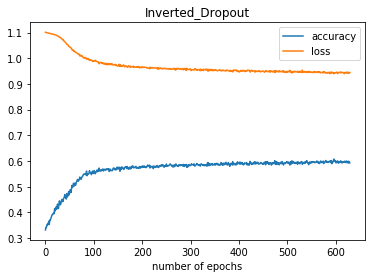

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(630),accuracies,label='accuracy')
plt.plot(range(630),losses,label='loss')
plt.legend()
plt.xlabel('number of epochs')
plt.title('Inverted_Dropout')
plt.savefig('wave 20/Inverted_Dropout.jpg')